In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import matplotlib
import seaborn as sns
import sys
import os
from os import path
import yaml
import copy
from scipy import stats
from statsmodels.stats.contingency_tables import Table2x2
from importlib import reload
import pickle
import PIL

In [94]:
os.chdir('/Volumes/Encrypted/Semiology-Visualisation-Tool/')
from mega_analysis.crosstab.mega_analysis.MEGA_ANALYSIS import MEGA_ANALYSIS
from mega_analysis.crosstab.mega_analysis import exclusions
from mega_analysis import Sankey_Functions
from mega_analysis.crosstab.mega_analysis.QUERY_SEMIOLOGY import QUERY_SEMIOLOGY
from mega_analysis.crosstab.NORMALISE_TO_LOCALISING_VALUES import NORMALISE_TO_LOCALISING_VALUES
from mega_analysis.crosstab.file_paths import file_paths
from mega_analysis.crosstab.lobe_top_level_hierarchy_only import top_level_lobes
from mega_analysis.crosstab.hierarchy_dictionaries import temporal_postcodes
from mega_analysis.semiology import recursive_items

In [95]:
from scripts.figures import interogate_queries, labels
from scripts.figures  import plotter

# Define lists & file paths

In [96]:
from pathlib import Path
# Define paths
repo_dir, resources_dir, excel_path, semiology_dict_path = file_paths()

Semio2Brain_Database = excel_path
with open(semiology_dict_path) as f:
    SemioDict = yaml.load(f, Loader=yaml.FullLoader)

In [11]:
region_names = labels.get_region_names()

In [12]:
semiology_list = list(recursive_items(SemioDict))

# Get df from Excel sheet & query df

If previously run notebook, get pickled results of MEGA_ANALYSIS, QUERY_SEMIOLOGY, normalisatione etc, and then go straight to Get sorted list of semiologies

In [97]:
region_names_re = region_names
region_names_re['top_level'] =  ['TL',
                     'FL',
                     'CING',
                     'PL',
                     'OL',
                     'INSULA',
                     'Hypothalamus',
                     'Cerebellum',]
region_names_re['top_level_all_other'] = ['Cerebellum']

In [161]:
with open('scripts/figures/data/sz_free_only_query_results_pickle.pkl', 'rb') as f:
    query_results = pickle.load(f)
    
with open('scripts/figures/data/sz_free_only_all_dfs_pickle.pkl', 'rb') as f:
    all_dfs = pickle.load(f)

In [62]:
# sz free only
with open('scripts/figures/data/sz_free_only_query_results_pickle.pkl', 'rb') as f:
    query_results = pickle.load(f)
with open('scripts/figures/data/sz_free_only_all_dfs_pickle.pkl', 'rb') as f:
    all_dfs = pickle.load(f)

If no pickle available, run:

In [99]:
from mega_analysis.crosstab.mega_analysis import MEGA_ANALYSIS

In [100]:
reload(MEGA_ANALYSIS)

<module 'mega_analysis.crosstab.mega_analysis.MEGA_ANALYSIS' from '/Volumes/Encrypted/Semiology-Visualisation-Tool/mega_analysis/crosstab/mega_analysis/MEGA_ANALYSIS.py'>

In [243]:
# Paeds free only
(original_df, 
df_ground_truth, df_study_type,
num_database_articles, num_database_patients, num_database_lat, num_database_loc) = \
                MEGA_ANALYSIS.MEGA_ANALYSIS(Semio2Brain_Database,
                              exclude_data = True,
                                  POST_ictals = True,
                                PET_hypermetabolism = True,
                                SPECT_PET = False,
                                CONCORDANCE = False,
                                paediatric_only = True
                             )
print(original_df.shape)

(270, 121)


In [110]:
# Exclude data = True
(original_df, 
df_ground_truth, df_study_type,
num_database_articles, num_database_patients, num_database_lat, num_database_loc) = \
                MEGA_ANALYSIS(Semio2Brain_Database,
                              exclude_data=True)
print(original_df.shape)

TypeError: 'module' object is not callable

In [244]:
redistribution_spec = {
    'FT': ['FL', 'INSULA', 'Lateral Temporal', 'TL'],
    'TO': ['Lateral Temporal', 'TL', 'OL'],
    'TP': ['Lateral Temporal', 'TL', 'PL'],
    'FTP': ['INSULA', 'Lateral Temporal', 'TL', 'FL', 'PL'],
    'TPO Junction': ['Lateral Temporal', 'TL', 'PL', 'OL'],
    'PO': ['PL', 'OL'],
    'FP': ['FL', 'PL'],
    'Perisylvian': ['INSULA', 'Lateral Temporal', 'TL', 'FL', 'PL'],
    'Sub-Callosal Cortex': ['Ant Cing (frontal, genu)', 'CING']
}

In [245]:
redistributed_df = copy.deepcopy(original_df)
for from_region, destination_regions in redistribution_spec.items():
    for destination in destination_regions:
        redistributed_df[destination] = original_df[destination].fillna(0) + original_df[from_region].fillna(0)
redistributed_df = redistributed_df.drop(redistribution_spec.keys(), 'columns')

In [246]:
region_names.keys()

dict_keys(['all', 'top_level', 'of_interest', 'of_interest_minus_tl', 'top_level_all_other', 'top_level_temporal', 'low_level_temporal_all', 'low_level_temporal_of_interest'])

In [247]:
def query_semiology_wrapper(df, semiology_list, semiology_dict_path):
    query_results = {}
    for semiology in semiology_list:
        query_inspection, num_query_lat, num_query_loc = QUERY_SEMIOLOGY(df,
                                                                     semiology_term=semiology,
                                                                     ignore_case=True,
                                                                     semiology_dict_path=semiology_dict_path,
                                                                     all_columns_wanted = True)
                                                                             # col1=col1, col2=col1)
            
        one_query_result = {
            'query_inspection': query_inspection,
            'num_query_lat': num_query_lat,
            'num_query_loc': num_query_loc
        }
        query_results[semiology] = one_query_result
    return query_results

In [248]:
from mega_analysis.crosstab.mega_analysis.exclusions import exclude_ET, exclude_cortical_stimulation, exclude_spontaneous_semiology, exclude_postictals 

df = copy.deepcopy(exclude_postictals(redistributed_df))
df_SS = exclude_ET(df)
df_SS = exclude_cortical_stimulation(df_SS)
df_TS = exclude_spontaneous_semiology(df)

all_dfs = {
    'full': df,
    'spontaneous': df_SS,
    'topology':  df_TS,
}

In [249]:
# sz_free_query_results = query_results

In [250]:
query_results_p = {}
for key, df in all_dfs.items():
    query_results_p[key] = query_semiology_wrapper(df, semiology_list, semiology_dict_path)

In [119]:
with open('scripts/figures/data/paeds_only_query_results_pickle.pkl', 'wb') as f:
    pickle.dump(query_results, f)
with open('scripts/figures/data/paeds_only_all_dfs_pickle.pkl', 'wb') as f:
    pickle.dump(all_dfs, f)

# (Skip to here if pickle loaded)
Get sorted list of semiologies

In [221]:
def sort_semiologies_by_n(query_result, top_n = 0, include_n = False):
    """
    Get semiologies in order of most frequently seen, based on query results
    
    Input:
    - query_results: a dictionary where keys are semiologies and values are
    'query_inspection' for that semiology, as returned by QUERY_SEMIOLOGY
    (often query_results['not_normalised']['full'])
    - top_n can be used to get the n semiologies with the highest number of cases
    - include_n = True to return the frequency of each semiology
    """
    n_results = []
    for k, v in query_result.items():
        n_results.append(v['num_query_loc'])
    n_results = np.array(n_results)
    
    labels = list(query_result.keys())
    sorted_result = np.sort(n_results)
    sorted_index = np.argsort(n_results)
    sorted_labels = [labels[i] for i in sorted_index]
    if include_n:
        return tuple(zip(sorted_labels[-top_n:], sorted_result[-top_n:]))
    else:
        return sorted_labels[-top_n:]

In [222]:
sorted_semiologies = sort_semiologies_by_n(query_results['full'])

In [57]:
# ali

# find all semiologies that occur more than 100 times in all and SS (localising as above, not datapoints)

#factor function
def semio_frequencies(dict_of_df, no_patients=100):
    i = 0
    j = 0
    full_semio = []
    full_loc_values = []
    full_semio_df = pd.DataFrame(columns=['Semiology', 'Localising'])
    for semio in dict_of_df.keys():
        n_localising = dict_of_df[semio]['num_query_loc']
        full_loc_values.append(n_localising)
        full_semio_df.loc[j, 'Semiology'] = semio
        full_semio_df.loc[j, 'Localising'] = n_localising
        j += 1
        if n_localising > no_patients:  # 410 for top 12
            i += 1
            # print(semio) 
            full_semio.append(semio)
    full_semio_df.set_index('Semiology', inplace=True)
    full_semio_df.sort_values(by=['Localising'], ascending=False, inplace=True)
    return full_semio, full_loc_values, full_semio_df

no_patients = 100

# all data
full_semio, full_loc_values, full_semio_df = semio_frequencies(query_results['full'], no_patients=no_patients)

# spontaneous SS data
SS_semio, SS_loc_values, SS_semio_df = semio_frequencies(query_results['spontaneous'], no_patients=no_patients)

# topological TS data
TS_semio, TS_loc_values, TS_semio_df = semio_frequencies(query_results['topology'], no_patients=no_patients)


over_100 = [i for i in SS_semio if i in full_semio and i in TS_semio]
print (len(over_100))
semiologies_100 = over_100

12


13795.0
3522.0
9931.0


/Users/karan/anaconda3/envs/semiology-vis/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


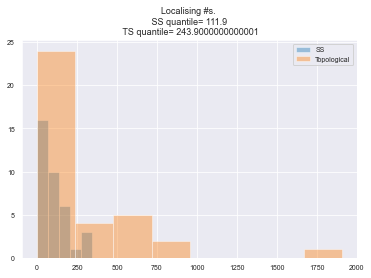

In [122]:
# ali: justification for using top occuring semiologies

print(np.sum(full_loc_values))
print(np.sum(SS_loc_values))
print(np.sum(TS_loc_values))

a = np.quantile(SS_loc_values, 0.66)
b = np.quantile(TS_loc_values, 0.66)

sns.distplot(SS_loc_values, kde=False, label='SS')
sns.distplot(TS_loc_values, kde=False, label='Topological')
plt.legend()
plt.title(f"Localising #s. \n SS quantile= {a} \n TS quantile= {b}")
plt.show()

# if we want to see the top 3rd of the most frequently occuring semiologies that occur in both spontaneous and topological studies, we use >104 for SS and >176 for TS.
# this gives us 10 semiologies rather than 12 above. the two differences are somatosensory and Vocalisation - so by showing the these 12 that occur more than 100 times in both databases, we are shoing more than the top 3rd of all the data in the Semio2Brain database.

In [123]:
# Epigastric should be = 741 for all-data # normalised or not makes no diff as loc data

# full_semio_df.to_csv(r'D:\Ali USB Backup\1 PhD\papers\SVT methods paper\semiology_localisations_list.csv')
# TS_semio_df.to_csv(r'D:\Ali USB Backup\1 PhD\papers\SVT methods paper\TS_localisations_list.csv')
# SS_semio_df.to_csv(r'D:\Ali USB Backup\1 PhD\papers\SVT methods paper\SS_localisations_list.csv')

# full_semio_df.sum()
full_semio_df.head()

,Localising
Semiology,
Automatisms - Oral & Manual,2298
Olfactory,980
Tonic,972
Non-Specific Aura,790
Dialeptic/LOA/LOC,754


# Plotter params

In [173]:
plt.rc('font', size=8)          # controls default text sizes
plt.rc('axes', titlesize=9)     # fontsize of the axes title
plt.rc('axes', labelsize=8)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=7)    # fontsize of the tick labels
plt.rc('ytick', labelsize=7)    # fontsize of the tick labels
plt.rc('legend', fontsize=7)    # legend fontsize
plt.rc('figure', titlesize=10) 

In [174]:
legend_labels = ['All studies', 'Spontaneous Semiology only']
# colors = ['#009988', '#cc3311'] # green, red
colors = [sns.color_palette("Greys")[3], sns.color_palette()[0]] # greys
# colors =  [(0.5085736255286428, 0.5085736255286428, 0.5085736255286428, 0.5), matplotlib.colors.colorConverter.to_rgba('black', alpha=.5)] #greys, transparent
# colors = [sns.color_palette("Greens")[3], sns.color_palette("Greens")[5]] # greens
# colors = [sns.color_palette("Greys")[4], sns.color_palette("Greens")[5]] # grey-greens
plotter_settings = {
    'ls': 'none',
    'linewidth': 1,
    'marker': 'o',
    'markeredgewidth': 1,
    'markersize': 3.5,
#     'markerfacecolor': 'white',
#     'alpha': 0.5
}

order_of_interest = ['FL','CING', 'PL', 'OL', 'INSULA', 'Hypothalamus',
                     'TL', 'Anterior (temporal pole)', 'Lateral Temporal', 'Mesial Temporal',
                     'Posterior Temporal', 'Basal (including Fusiform OTMG)',]

# Bold top level lobes, not temporal subregions
special_y_mask = [not region in region_names['low_level_temporal_of_interest'] for region in order_of_interest]
special_y_index = [i for i, val in enumerate(special_y_mask) if val]

---
# Figure 1 - P (Localisation | Semiology)
---

In [251]:
results_p = {}
reload(interogate_queries)
for study_type, query_result in query_results_p.items():
    result = interogate_queries.summarise_query(
        query_result,
        axis = 'semiology', # 'zone'
        region_names = region_names_re,
        normalise = True,
        temporal_status = 'both',
        semiologies_of_interest = semiologies_100,
        drop_other_semiology = True,
        merge_other_regions = True,
        drop_other_regions = True,
        confint_method = 'bootstrap',
        bootstrapping_samples = 100, 
        order_of_regions = order_of_interest)
    
    results_p[study_type] = result

/Volumes/Encrypted/Semiology-Visualisation-Tool/scripts/figures/interogate_queries.py:415: RuntimeWarning: invalid value encountered in true_divide
  top_level_ratio = (localising.values.T/all_regions.sum(1).values)[0]


In [225]:
results['full']['proportion'].to_csv('scripts/figures/working_figures_5/adults_only/Prob_full.csv', header=True, index=True)

In [226]:
results['full']['confints'][0].to_csv('scripts/figures/working_figures_5/adults_only/Prob_full_lower_CI.csv', header=True, index=True)

In [227]:
results['full']['confints'][1].to_csv('scripts/figures/working_figures_5/adults_only/Prob_full_upper_CI.csv', header=True, index=True)

In [239]:
full_p_p = pd.read_csv('scripts/figures/working_figures_5/paeds_only/Prob_full.csv')
confints_2_p_p = pd.read_csv('scripts/figures/working_figures_5/paeds_only/Prob_full_lower_CI.csv')
contints_2_p_p = pd.read_csv('scripts/figures/working_figures_5/paeds_only/Prob_full_upper_CI.csv')

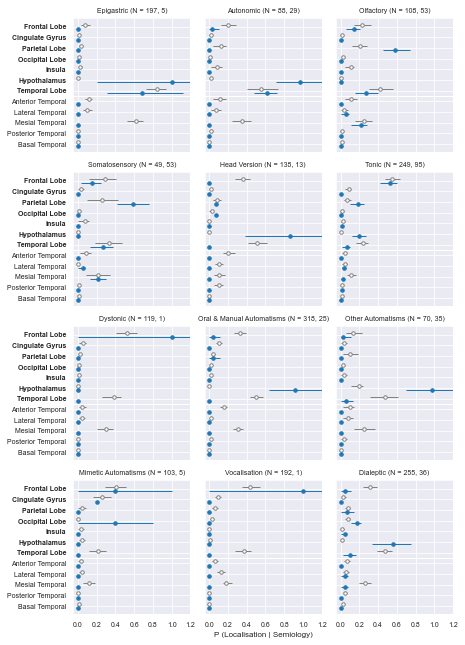

In [293]:
sns.set_style("darkgrid")
reload(plotter)

fig, axs = plotter.plot_proportion_ci_forest_plot(
                               proportion_df_1 = results['full']['proportion'],
                               confint_df_1 = results['full']['confints'],
                               counts_df_1 = results['full']['counts'],
                               colors = colors,
                               legend_labels = legend_labels,
                               proportion_df_2 = results_p['spontaneous']['proportion'],
                               confint_df_2 = results_p['spontaneous']['confints'],
                               counts_df_2 = results_p['spontaneous']['counts'],
                               y_labels = labels.clean_localisations(results['full']['proportion'].columns),
                               overlapping = False,
                               ax_titles = labels.clean_semiologies(results['full']['proportion'].index),
                               plotter_settings = plotter_settings,
                               xlim = [-.05,1.2],
                               xticks = np.arange(0, 1.21, 0.2),
#                                n= options - can omit. N=Datapoints. n=#of semiologies.
                               fontsize=7,
                               special_y_titles = special_y_index,
                                figsize = (6.5, 9),
                              )
localising_n = query_results, 
# plt.legend('bottom_right')
plt.savefig(f'scripts/figures/working_figures_5/adults_vs_paeds/fig-1.png', dpi=300, pad_inches=0.5)
# plt.savefig(repo_dir / 'images' / 'Brain' / 'test_fig-1_raw_10-bootstrap_zone.eps', dpi=300, pad_inches=0.5)

_______
# Figure 2: By zone
________

In [73]:
results = {}
reload(interogate_queries)
for study_type, query_result in query_results.items():
    result = interogate_queries.summarise_query(
        query_result,
        axis = 'zone',
        region_names = region_names_re,
        normalise = True,
        temporal_status = 'both',
        semiologies_of_interest = semiology_list,
        drop_other_semiology = True,
        merge_other_regions = True,
        drop_other_regions = True,
        confint_method = 'bootstrap',
        bootstrapping_samples = 1000, 
    order_of_regions = order_of_interest)
    
    results[study_type] = result

/Volumes/Encrypted/Semiology-Visualisation-Tool/scripts/figures/interogate_queries.py:415: RuntimeWarning: invalid value encountered in true_divide
  top_level_ratio = (localising.values.T/all_regions.sum(1).values)[0]


<Figure size 432x288 with 0 Axes>

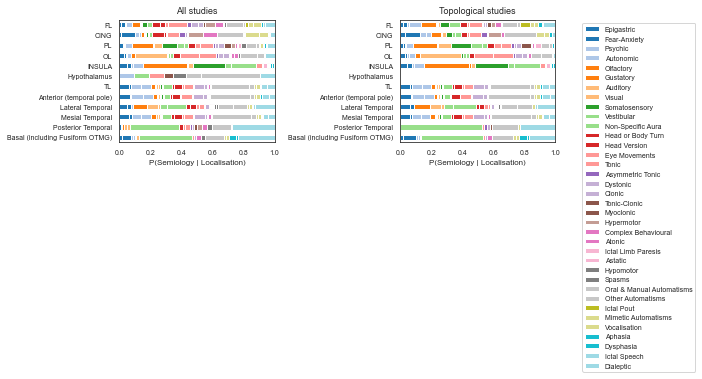

In [74]:
axis = 'zone'

sns.set_style('white')
sns.despine(left=True)
counts_form = 'raw_counts'

y_sums_1 = [int(n) for n in results['full'][counts_form].sum(0)]
y_sums_2 = [int(n) for n in results['topology'][counts_form].sum(0)]

combine_labels_1 = [label+f' (n={n})' for n, label in zip(y_sums_1, labels.clean_localisations(results['full']['counts'].columns))]
n_labels_1 = [f'n={n}' for n in y_sums_1]
n_labels_2 = [f'n={n}' for n in y_sums_2]

color_palette =  sns.color_palette("tab20", 
                                    as_cmap=True
                                    )
fig, axs = plt.subplots(1, 2, sharex=True, sharey=False,)
plotter.plot_stacked_hbar(results['full']['proportion'],
                          ax=axs[0],
                          ax_title='All studies',
                          axis=axis,
                          color_palette=color_palette, )
#                          special_y_titles = special_y_index)

plotter.plot_stacked_hbar(results['topology']['proportion'],
                          ax=axs[1],
                          ax_title='Topological studies',
                          axis=axis,
                          color_palette=color_palette)

axs[0].get_legend().remove()
axs[1].legend(bbox_to_anchor=(1.15,1), loc="upper left", labels=labels.clean_semiologies(results['full']['proportion'].index))

# axs[0].set_yticklabels(combine_labels_1[::-1])
# axs[1].set_yticklabels(n_labels_2[::-1])

plt.tight_layout()
# plt.savefig(f'scripts/figures/working_f

In [304]:
melted = results['full']['proportion'].reset_index().melt(id_vars=['index'], var_name=['localisation'])

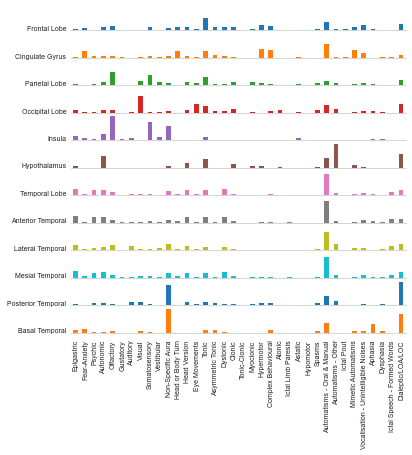

In [306]:
sns.set_style("whitegrid")
axs = results['full']['proportion'].plot(kind='bar', subplots=True, sharey=True, 
              figsize=(6, 6), legend=False, yticks=[], 
              grid=False, ylim=(0, 0.27), edgecolor='none')

sns.despine(left=True)
for ax in axs:
    ax.set_title('')
    sername = ax.get_legend_handles_labels()[1][0]
    ax.text(-1, 0, labels.clean_localisations(sername)[0], fontsize=7, ha='right')

plt.subplots_adjust(wspace = 0.001, hspace = 0.15)
# plt.tight_layout()
# plt.savefig(f'scripts/figures/working_figures_2/fig-2/bar/panel_bar.png', dpi=300, pad_inches=3)

In [307]:
# results = {}
# reload(interogate_queries)
# for study_type, query_result in query_results.items():
#     result = interogate_queries.summarise_query(
#         query_result,
#         axis = 'zone',
#         region_names = region_names,
#         normalise = True,
#         temporal_status = 'both',
#         semiologies_of_interest = core_semiologies,
#         drop_other_semiology = True,
#         merge_other_regions = True,
#         drop_other_regions = False,
#         confint_method = 'bootstrap',
#         bootstrapping_samples = 1000, 
#     order_of_regions = order_of_interest)
    
#     results[study_type] = result

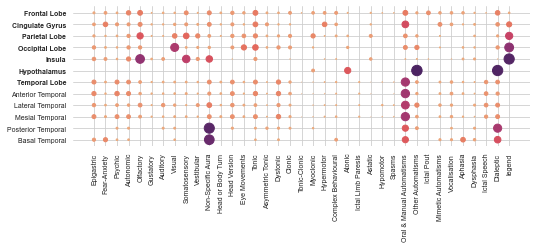

In [309]:
counts_form = 'counts'
results_form = 'topology'
df = copy.deepcopy(results[results_form]['proportion'])
df.loc['legend'] = np.zeros(df.shape[1])
df.iloc[-1,0] = 0.01
df.iloc[-1,1] = 0.1
df.iloc[-1,2] = 0.2
df.iloc[-1,3] = 0.3
df.iloc[-1,4] = 0.4

x = list(range(df.shape[0]))*df.shape[1]
y = []
for i in range(df.shape[1]):
    y += [i]*df.shape[0]

s = df.T.values.flatten() 

y_sums_1 = [int(n) for n in results[results_form][counts_form].sum(0)]
combine_labels_1 = [label+f' ({n})' for n, label in zip(y_sums_1, labels.clean_localisations(df.columns))]
n_labels_1 = [f'{n}' for n in y_sums_1]

sns.set_style('whitegrid')
fig, axs = plt.subplots(figsize=(7.5, 4))
scatter = plt.scatter(x,
            y,
            s=s*260,
            c=s,
            cmap='flare',
            )
# labels.clean_localisations(df.columns)
plt.yticks(range(df.shape[1]), labels.clean_localisations(df.columns))
plt.xticks(range(df.shape[0]), labels.clean_semiologies(df.index), rotation=90)

axs.invert_yaxis()

special_y_titles = special_y_index
inverse_special_titles = [f for f in range(results['full']['proportion'].shape[0]) if f not in special_y_titles]
for y in special_y_titles:
    axs.get_yticklabels()[y].set_weight("bold")
for y in inverse_special_titles:
    # axs[ax_n, 0].get_yticklabels()[y].set_color("dimgrey")
    pass

plt.tight_layout()
sns.despine(left=True, bottom=True)
plt.gca().set_aspect("equal")

# plt.legend(*scatter.legend_elements("colors", num=5))
# handles, label = scatter.legend_elements(prop="sizes", alpha=0.6)
# legend2 = axs.legend(handles, label, loc="upper right", title="Sizes")

# plt.savefig(f'scripts/figures/working_figures_3/fig-2/topology/topology_labels_key.png', dpi=300, pad_inches=0.5)

AttributeError: 'silent_list' object has no attribute 'set_weight'

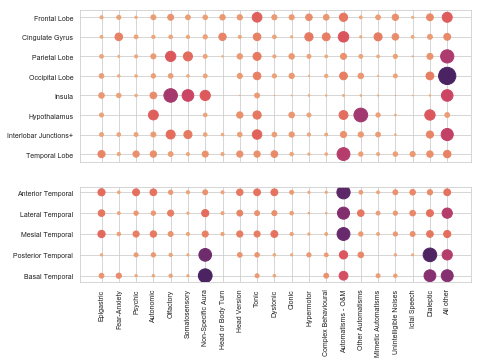

In [334]:
df_1 = results['full']['proportion'].iloc[:,:8]
df_2 = results['full']['proportion'].iloc[:,8:]

sns.set_style('whitegrid')
fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharey=False, sharex=True, gridspec_kw={'height_ratios': [8, 5]})

for ax_n, df in enumerate([df_1, df_2]):
    x = list(range(df.shape[0]))*df.shape[1]
    y = []
    for i in range(df.shape[1]):
        y += [i]*df.shape[0]
        
    s = df.T.values.flatten()    
    
    axs[ax_n].scatter(x,
                y,
                s=s*700,
                c=s,
                cmap='flare',
                )
    
    plt.sca(axs[ax_n])
    plt.yticks(range(df.shape[1]), labels.clean_localisations(df.columns))
    plt.xticks(range(df.shape[0]), labels.clean_semiologies(df.index), rotation=90)
    axs[ax_n].invert_yaxis()

axs[0].get_yticklabels().set_weight("bold")

#     special_y_titles = special_y_index
#     inverse_special_titles = [f for f in range(results['full']['proportion'].shape[0]) if f not in special_y_titles]
#     for y in special_y_titles:
#         axs.get_yticklabels()[y].set_weight("bold")
#     for y in inverse_special_titles:
#         # axs[ax_n, 0].get_yticklabels()[y].set_color("dimgrey")
#         pass

plt.tight_layout()
plt.savefig(f'scripts/figures/working_figures_2/fig-2/heatmap/heat_size_map_split.eps', dpi=300, pad_inches=0.5)

# spearman's for brain ROIs: Generative similarity ?structutal and functional connectivity

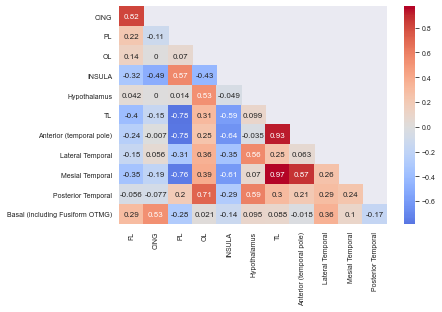

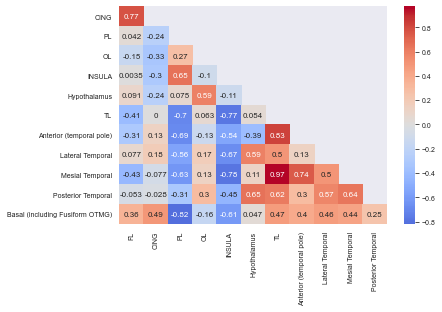


 correlation between all and TS
FL 0.008239768712338441
CING 0.0003316683391269209
PL 0.0022231354099909208
OL 0.011374198642690932
INSULA 0.0003547590073493126
Hypothalamus 0.020781098744326612
TL 0.0034464502618274493
Anterior (temporal pole) 0.000521133700481005
Lateral Temporal 9.5435818268384e-07
Mesial Temporal 0.00041811794041499725
Posterior Temporal 0.00035903023787490015
Basal (including Fusiform OTMG) 0.0001343354722529837


In [330]:
# spearman's for brain ROIs

df_ROI_all = results['full']['proportion']
df_ROI_TS = results['topology']['proportion']

# # check distributions
# sns.jointplot(x="FL", y="PL", data=df_ROI_all, alpha=0.4)
# sns.jointplot(x="CING", y="FL", data=df_ROI_TS, alpha=0.4, color='red')
# plt.show()

# correlations
corr_all = df_ROI_all.corr(method = 'spearman')
corr_TS = df_ROI_TS.corr(method = 'spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_all, dtype=bool))
mask = mask[1:, :-1]
corr_all_diag = corr_all.iloc[1:,:-1].copy()
corr_TS_diag = corr_TS.iloc[1:,:-1].copy()

a = sns.heatmap(corr_all_diag, annot = True, cmap='coolwarm', center=0, mask=mask)
plt.yticks(rotation=0)
plt.show()
sns.heatmap(corr_TS_diag, annot = True, cmap='coolwarm', center=0, mask=mask)
plt.savefig(repo_dir / 'images' / 'Brain' / 'Spearman_Correlations_TS.png', dpi=300, pad_inches=0.5)
plt.show()

# check the correlation between the all and TS dataframes
from scipy.stats import spearmanr
print('\n correlation between all and TS')
for lobe in df_ROI_all:
    r, p = spearmanr(df_ROI_all[lobe], df_ROI_TS[lobe])
    print (lobe, p) #  hypothalamus has the biggest change from all to TS with p=0.014 with bonferroni, FL is also not correlated (p>0.05/8+) ie changes from all to TS

# corr_all
corr_TS.to_csv(repo_dir / 'images' / 'Brain' / 'Spearman_Correlations_TSfilter.csv')

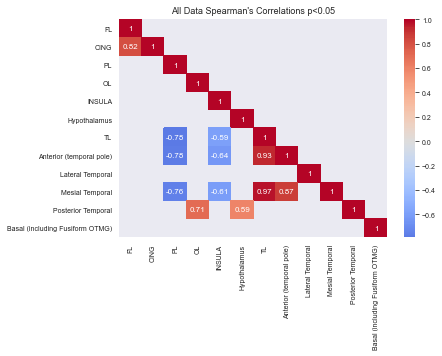

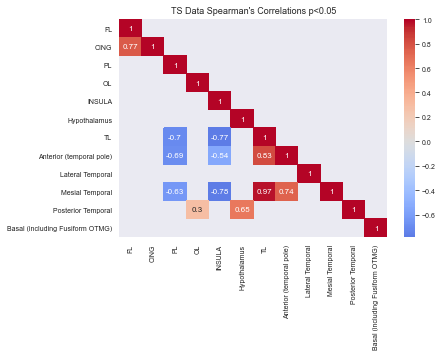

In [331]:
# only significant associations:

def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = spearmanr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix

# get p values and mask
p_values_all = corr_sig(df_ROI_all)
mask_all = np.invert(np.tril(p_values_all<0.05))
p_values_TS = corr_sig(df_ROI_all)
mask_TS = np.invert(np.tril(p_values_TS<0.05))

# plot with mask
corr_all = df_ROI_all.corr(method = 'spearman')
a = sns.heatmap(corr_all, annot = True, cmap='coolwarm', center=0, mask=mask_all)
plt.title("All Data Spearman's Correlations p<0.05")
plt.yticks(rotation=0)
plt.show()

corr_TS = df_ROI_TS.corr(method = 'spearman')
sns.heatmap(corr_TS, annot = True, cmap='coolwarm', center=0, mask=mask_TS)
plt.title("TS Data Spearman's Correlations p<0.05")
plt.savefig(repo_dir / 'images' / 'Brain' / 'Spearman_Correlations_TS_significant.png', dpi=300, pad_inches=0.5)
plt.show()

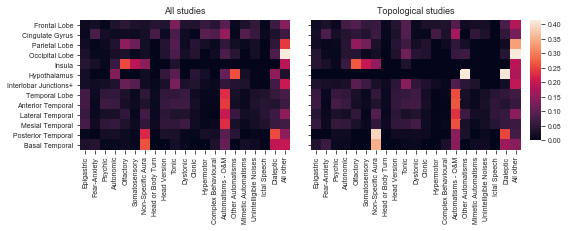

In [278]:
sns.set_style('ticks')
fig, axs = plt.subplots(1, 2, figsize=(7.5, 2.9), sharey=True, sharex=True)
cbar_ax = fig.add_axes([0.99, .38, .02, 0.576])
cbar_ax.patch.set_edgecolor('black')  
cbar_ax.patch.set_linewidth('1')  
plt.tight_layout()

heatmap_kwargs = {
    'square': True,
#      'xticklabels': x_labels
#     'vmin': 0.0,
#     'vmax': 1.0,
}

sns.heatmap(results['full']['proportion'].T, ax=axs[0], cbar=False, **heatmap_kwargs)
sns.heatmap(results['topology']['proportion'].T, ax=axs[1], cbar=True, cbar_ax = cbar_ax, **heatmap_kwargs)

axs[0].set_yticklabels(labels.clean_localisations(results['topology']['proportion'].columns), rotation=0)
axs[0].set_xticklabels(labels.clean_semiologies(results['topology']['proportion'].index))
axs[0].set_title('All studies')
axs[1].set_title('Topological studies')

# fig.colorbar(im, orientation="horizontal", pad=0.2)

plt.tight_layout()
plt.savefig(f'scripts/figures/working_figures_2/fig-2/heatmap/heatmap.eps', dpi=300, pad_inches=0.5)

# 2b - Region-specific subplots

- Q - use full, SS or topology?
- ***NOT RIGHT - NEEDS TO BE REWRTTTEN WITH NEW NORMALISATION

In [663]:
def get_specific_df(query_results, columns_of_interest):
    counts_matrix = []
    for semiology, value in query_results.items():
        query_inspection = value['query_inspection']
        semiology_counts = query_inspection[columns_of_interest].sum().values
        counts_matrix.append(semiology_counts)
    counts_df = pd.DataFrame(counts_matrix, index=query_results.keys(), columns=columns_of_interest)
    return counts_df

In [34]:
axis = 'zone'
normalised_or_not = 'normalised'

In [35]:
#Cingulate
cing_processed_dfs = {}
columns_of_interest = ['CING', 'Ant Cing (frontal, genu)', 'Post Cing', ]
for query_result_name, query_result in query_results[normalised_or_not].items():
    counts_df = get_specific_df(query_result, columns_of_interest)
    counts_df['Cingulate - (anterior + posterior)'] = counts_df['CING'] - (counts_df['Post Cing'] + counts_df['Ant Cing (frontal, genu)'])
    counts_df = interogate_queries.merge_all_other_semiologies(counts_df, sorted_semiologies[-20:])
    proportion_df = interogate_queries.calculate_proportions(counts_df, axis)
    confint_dfs = interogate_queries.calculate_confint(counts_df, axis = axis, method = 'binomial', alpha=0.05)
    cing_processed_dfs[query_result_name] = {
        'counts': counts_df,
        'proportion': proportion_df,
        'confints': confint_dfs
    }

/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/statsmodels/stats/proportion.py:137: RuntimeWarning: invalid value encountered in sqrt
  dist = crit * np.sqrt(q_ * (1. - q_) / nobs + crit2 / (4. * nobs**2))


In [36]:
# SMA
sma_processed_dfs = {}
columns_of_interest = ['SSMA', 'SMA (pre-central gyrus; posterior SFG, MFG)', 'FL']
for query_result_name, query_result in query_results[normalised_or_not].items():
    counts_df = get_specific_df(query_result, columns_of_interest)
    counts_df['SMA'] = counts_df['SSMA'] + counts_df['SMA (pre-central gyrus; posterior SFG, MFG)']
    counts_df['FL-SMA'] = counts_df['FL'] - counts_df['SMA']
    counts_df = counts_df.drop(['SMA (pre-central gyrus; posterior SFG, MFG)', 'SSMA'], 1)
    counts_df = interogate_queries.merge_all_other_semiologies(counts_df, sorted_semiologies[-20:])
    proportion_df = interogate_queries.calculate_proportions(counts_df, axis)
    confint_dfs = interogate_queries.calculate_confint(counts_df, axis = axis, method = 'binomial', alpha=0.05)
    sma_processed_dfs[query_result_name] = {
        'counts': counts_df,
        'proportion': proportion_df,
        'confints': confint_dfs
    }

In [37]:
# PL
pl_processed_dfs = {}
columns_of_interest = ['PL',
                       'Primary Sensory Cortex (post-central gyrus)',
                       'medial anterior parietal',
                       'Sup. pariet. lobule',
                       'Inferior Parietal Lobule',]
for query_result_name, query_result in query_results[normalised_or_not].items():
    counts_df = get_specific_df(query_result, columns_of_interest)
    counts_df = interogate_queries.merge_all_other_semiologies(counts_df, sorted_semiologies[-20:])
    proportion_df = interogate_queries.calculate_proportions(counts_df, axis)
    confint_dfs = interogate_queries.calculate_confint(counts_df, axis = axis, method = 'binomial', alpha=0.05)
    pl_processed_dfs[query_result_name] = {
        'counts': counts_df,
        'proportion': proportion_df,
        'confints': confint_dfs
    }

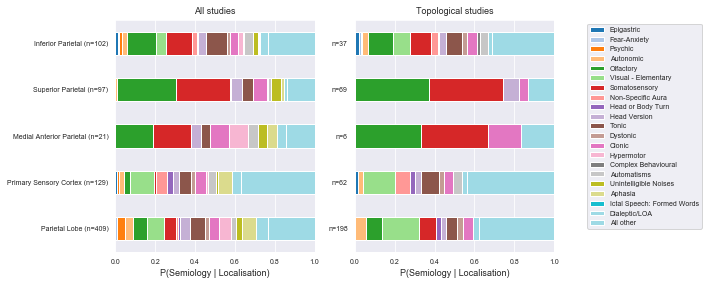

In [39]:
sns.set_style('darkgrid')
fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(20, 2.5))

#Choose from {cing_processed_dfs, pl_processed_dfs, sma_processed_dfs}
processed_dfs = copy.deepcopy(pl_processed_dfs)

y_labels = labels.clean_localisations(processed_dfs['full']['counts'].columns)
y_sums_1 = [int(n) for n in processed_dfs['full']['counts'].sum()]
y_sums_2 = [int(n) for n in processed_dfs['topology']['counts'].sum()]

combine_labels_1 = [label+f' (n={n})' for n, label in zip(y_sums_1, y_labels)]
n_labels_1 = [f'n={n}' for n in y_sums_1]
n_labels_2 = [f'n={n}' for n in y_sums_2]

plot_stacked_hbar(processed_dfs['full']['proportion'], ax=axs[0], ax_title='All studies', axis=axis, color_palette=color_palette)
plot_stacked_hbar(processed_dfs['topology']['proportion'], ax=axs[1], ax_title='Topological studies', axis=axis, color_palette=color_palette)

axs[0].get_legend().remove()
axs[0].set_yticklabels(combine_labels_1)
axs[1].set_yticklabels(n_labels_2)
axs[1].legend(bbox_to_anchor=(1.15,1), loc="upper left", labels=labels.clean_semiologies(processed_dfs['topology']['proportion'].index))

plt.tight_layout()
# plt.savefig('/Users/karan/Downloads/PL.png', dpi=300, pad_inches=0.5)

---
# Figure 3: Odds ratio
---

Odds of semiology 1 localising to lobe A, divided by odds of NotSemiology A localising to lobe A. NotSemiology can be obtained by removing the result of QUERY_SEMIOLOGY from the original_df.
This gives Relative localising values. Interpret as intrinsic values of a specific semiology vs other semiologies. Narrow clinical history question.

In [296]:
def odds_ratio_df(counts, total_row, log_odds=False):
    melted = counts.reset_index().melt(id_vars='index')
    melted = melted.rename(columns={'index': 'semiology', 'variable': 'localisation', 'value': 'a'})
    melted['localisation_total'] = np.zeros(len(melted))
    for localisation, total in total_row.to_dict().items():
        mask = melted['localisation'] == localisation
        melted.loc[mask, 'localisation_total'] = total
        
    melted['c'] = melted['localisation_total'] - melted['a']
    
    melted['semiology_total'] = np.zeros(len(melted))
    for semiology, total in counts.sum(1).to_dict().items():
        mask = melted['semiology'] == semiology
        melted.loc[mask, 'semiology_total'] = total
        
    melted['b'] = melted['semiology_total']-melted['a']
    
    melted['d'] = np.repeat(total_row.sum(), len(melted)) - (melted['a'] + melted['b'] + melted['c'])
    
    melted['OR'] = np.nan
    melted['OR_lower_ci'] = np.nan
    melted['OR_upper_ci'] = np.nan
    
    for i in melted.index:
        contingency_table = Table2x2(
        [[melted.loc[i, 'a'], melted.loc[i, 'b']],
         [melted.loc[i, 'c'], melted.loc[i, 'd']]] )
        
        if not log_odds:
            melted.loc[i, 'OR'] = contingency_table.oddsratio
            melted.loc[i, 'OR_lower_ci'] = contingency_table.oddsratio_confint(alpha = 0.05)[0]
            melted.loc[i, 'OR_upper_ci'] = contingency_table.oddsratio_confint(alpha = 0.05)[1]
        else:
            melted.loc[i, 'OR'] = contingency_table.log_oddsratio
            melted.loc[i, 'OR_lower_ci'] = contingency_table.log_oddsratio_confint(alpha = 0.05)[0]
            melted.loc[i, 'OR_upper_ci'] = contingency_table.log_oddsratio_confint(alpha = 0.05)[1]

    or_pivot = melted.pivot_table(index=['semiology',], columns='localisation', values='OR')
    or_l_pivot = melted.pivot_table(index=['semiology',], columns='localisation', values='OR_lower_ci')
    or_u_pivot = melted.pivot_table(index=['semiology',], columns='localisation', values='OR_upper_ci')
    
    or_dfs = {
        'counts': counts,
        'or': or_pivot,
        'confints': (or_l_pivot, or_u_pivot)
    }
    
    return or_dfs

In [295]:
normalised = True
if normalised:
    count_type = 'counts'
    row_type = 'normalised_row'
else:
    count_type = 'raw_counts'
    row_type = 'raw_row'

In [297]:
results = {}
for study_type, query_result in query_results.items():
    result = interogate_queries.summarise_query(
        query_result,
        axis = 'semiology', # 'zone'
        region_names = region_names_re,
        normalise = normalised,
        temporal_status = 'both',
        semiologies_of_interest = semiologies_100,
        drop_other_semiology = True,
        merge_other_regions = False,
        drop_other_regions = False,
        confint_method = 'bootstrap',
        bootstrapping_samples = 100, 
        order_of_regions = order_of_interest)
    
    results[study_type] = result

/Volumes/Encrypted/Semiology-Visualisation-Tool/scripts/figures/interogate_queries.py:415: RuntimeWarning: invalid value encountered in true_divide
  top_level_ratio = (localising.values.T/all_regions.sum(1).values)[0]


In [312]:
total_rows = {}
for study_type in all_dfs.keys():
    total_row = all_dfs[study_type][region_names_re['low_level_temporal_of_interest'] + region_names_re['top_level']].sum()
    top_level_sums = all_dfs[study_type][region_names_re['top_level']].sum()
    temporal_sums = all_dfs[study_type][region_names_re['low_level_temporal_of_interest']].sum()
    
    localising_sum = all_dfs[study_type]['Localising'].sum()
    top_level_ratio = localising_sum/top_level_sums.sum()
    top_level_normalised = top_level_ratio*top_level_sums

    temporal_ratio = top_level_normalised['TL'] / temporal_sums.sum()
    temporal_normalised = temporal_ratio * temporal_sums
    normalised_row = pd.concat([temporal_normalised, top_level_normalised])
    total_rows[study_type] = {
        'raw_row': total_row,
        'normalised_row': normalised_row
    }

In [318]:
total_rows['full']['normalised_row']

Anterior (temporal pole)            34.406962
Lateral Temporal                    34.406962
Mesial Temporal                     99.599100
Posterior Temporal                  21.730713
Basal (including Fusiform OTMG)      0.000000
TL                                 190.143737
FL                                 216.763860
CING                                18.063655
PL                                 156.868583
OL                                 167.326489
INSULA                               8.556468
Hypothalamus                       159.720739
Cerebellum                           8.556468
dtype: float64

In [317]:
results['full']['counts']

,FL,CING,PL,OL,INSULA,Hypothalamus,TL,Anterior (temporal pole),Lateral Temporal,Mesial Temporal,Posterior Temporal,Basal (including Fusiform OTMG)
Epigastric,27.793289,5.750336,8.625503,8.625503,80.504698,0.000000,582.700671,214.217436,38.749229,326.078418,0.731118,2.924470
Autonomic,70.666667,6.424242,20.190476,2.753247,114.718615,1.835498,419.411255,171.277895,17.566964,227.638570,2.195870,0.731957
Olfactory,74.827692,9.916923,45.076923,10.818462,480.520000,0.000000,257.840000,76.002424,34.804848,144.191515,1.420606,1.420606
Somatosensory,44.789199,6.670732,25.729965,3.811847,364.984321,0.000000,101.013937,42.360683,3.258514,54.091334,0.651703,0.651703
Head Version,77.099656,6.831615,16.591065,10.735395,0.975945,0.000000,455.766323,178.652278,31.467163,242.601673,3.045209,0.000000
Tonic,223.791045,35.731343,31.029851,13.164179,63.940299,0.940299,450.402985,195.034314,21.748431,230.112429,1.403125,2.104687
Dystonic,76.882255,8.092869,5.058043,1.011609,1.011609,0.000000,517.943615,200.175782,23.338880,293.531304,0.000000,0.897649
Automatisms - Oral & Manual,198.493151,70.958904,23.972603,24.931507,9.589041,0.958904,1911.095890,739.592665,130.728782,1023.440241,7.222585,10.111618
Automatisms - Other,23.742765,2.739550,11.871383,4.565916,8.218650,22.829582,210.032154,57.408789,39.206002,109.216720,4.200643,0.000000
Mimetic Automatisms,63.804878,38.738676,6.076655,0.000000,4.557491,5.317073,99.505226,33.831777,13.930732,49.752613,0.000000,1.990105


In [319]:
odds_dfs = {}
for data_type in ['full', 'spontaneous']:
    odds_dfs[data_type] = odds_ratio_df(results[data_type][count_type], total_rows[data_type][row_type], log_odds = False)
#     odds_dfs[data_type] = interogate_queries.order_regions(odds_dfs[data_type], order_of_interest)    

/Users/karan/anaconda3/envs/semiology-vis/lib/python3.7/site-packages/statsmodels/stats/contingency_tables.py:698: RuntimeWarning: invalid value encountered in log
  return np.dot(np.log(f), np.r_[1, -1, -1, 1])
/Users/karan/anaconda3/envs/semiology-vis/lib/python3.7/site-packages/statsmodels/stats/contingency_tables.py:715: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.sum(1 / self.table))
/Users/karan/anaconda3/envs/semiology-vis/lib/python3.7/site-packages/statsmodels/stats/contingency_tables.py:698: RuntimeWarning: divide by zero encountered in log
  return np.dot(np.log(f), np.r_[1, -1, -1, 1])
/Users/karan/anaconda3/envs/semiology-vis/lib/python3.7/site-packages/statsmodels/stats/contingency_tables.py:715: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(np.sum(1 / self.table))
/Users/karan/anaconda3/envs/semiology-vis/lib/python3.7/site-packages/statsmodels/stats/contingency_tables.py:698: RuntimeWarning: invalid value encountere

In [254]:
odds_dfs_a = odds_dfs

In [323]:
odds_dfs_a['full']['confints'][0]

localisation,FL,CING,PL,OL,INSULA,Hypothalamus,TL,Anterior (temporal pole),Lateral Temporal,Mesial Temporal,Posterior Temporal,Basal (including Fusiform OTMG)
semiology,,,,,,,,,,,,
Automatisms - Oral & Manual,0.337108,0.640847,0.147881,0.250623,0.017973,0.008758,1.302002,1.192100,0.922963,1.210398,0.162985,0.252831
Automatisms - Other,0.304730,0.082922,0.661463,0.271600,0.162599,19.898320,0.931486,0.554934,2.189057,0.856928,0.793472,0.014011
Autonomic,0.509557,0.133805,0.592048,0.056233,2.130227,0.144982,0.873134,0.924888,0.342786,0.885415,0.126655,0.015132
Dialeptic/LOA/LOC,1.101876,0.351722,0.897745,1.772170,0.048620,2.025809,0.875167,0.480738,0.912230,0.960903,4.405154,2.636726
Dystonic,0.524018,0.171693,0.084794,0.008877,0.002330,0.009506,1.152195,1.050374,0.458125,1.170328,0.006167,0.021608
Epigastric,0.129909,0.091553,0.154201,0.241929,1.050527,0.008179,1.115035,0.963598,0.746339,1.124609,0.012647,0.155297
Head Version,0.587550,0.150696,0.474388,0.420806,0.002407,0.010543,1.076381,1.017571,0.743813,1.010813,0.223587,0.006544
Mimetic Automatisms,1.810464,5.439362,0.416179,0.007165,0.111459,2.846971,0.536969,0.465116,0.906449,0.509057,0.023017,0.357113
Olfactory,0.502290,0.224370,1.549043,0.379835,28.840499,0.009426,0.363297,0.303250,0.753473,0.438004,0.054432,0.052047


In [301]:
odds_dfs_a['full']['confints'][0]

localisation,FL,CING,PL,OL,INSULA,Hypothalamus,TL,Anterior (temporal pole),Lateral Temporal,Mesial Temporal,Posterior Temporal,Basal (including Fusiform OTMG)
semiology,,,,,,,,,,,,
Automatisms - Oral & Manual,0.337108,0.640847,0.147881,0.250623,0.017973,0.008758,1.302002,1.192100,0.922963,1.210398,0.162985,0.252831
Automatisms - Other,0.304730,0.082922,0.661463,0.271600,0.162599,19.898320,0.931486,0.554934,2.189057,0.856928,0.793472,0.014011
Autonomic,0.509557,0.133805,0.592048,0.056233,2.130227,0.144982,0.873134,0.924888,0.342786,0.885415,0.126655,0.015132
Dialeptic/LOA/LOC,1.101876,0.351722,0.897745,1.772170,0.048620,2.025809,0.875167,0.480738,0.912230,0.960903,4.405154,2.636726
Dystonic,0.524018,0.171693,0.084794,0.008877,0.002330,0.009506,1.152195,1.050374,0.458125,1.170328,0.006167,0.021608
Epigastric,0.129909,0.091553,0.154201,0.241929,1.050527,0.008179,1.115035,0.963598,0.746339,1.124609,0.012647,0.155297
Head Version,0.587550,0.150696,0.474388,0.420806,0.002407,0.010543,1.076381,1.017571,0.743813,1.010813,0.223587,0.006544
Mimetic Automatisms,1.810464,5.439362,0.416179,0.007165,0.111459,2.846971,0.536969,0.465116,0.906449,0.509057,0.023017,0.357113
Olfactory,0.502290,0.224370,1.549043,0.379835,28.840499,0.009426,0.363297,0.303250,0.753473,0.438004,0.054432,0.052047


In [277]:
odds_dfs_a['full']['confints'][1].shape

(12, 12)

In [280]:
odds_dfs['full']['confints'][0].shape

(6, 12)

KeyError: 'Automatisms - Oral & Manual'

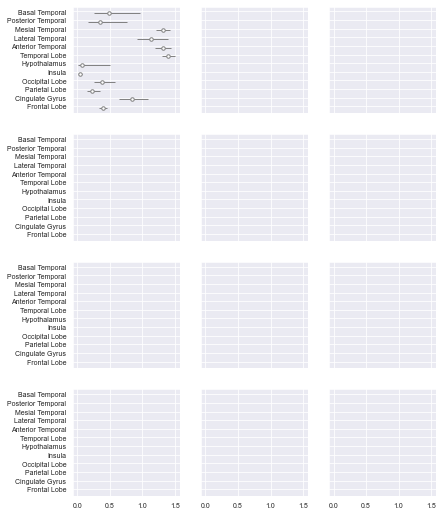

In [306]:
sns.set_style('darkgrid')

plotter.plot_proportion_ci_forest_plot(
    proportion_df_1 = odds_dfs_a['full']['or'],
    confint_df_1 = [df for df in odds_dfs_a['full']['confints']],
    counts_df_1 = odds_dfs_a['full']['counts'],
    colors = colors,
    legend_labels = legend_labels,
    proportion_df_2 = odds_dfs['full']['or'],
    confint_df_2 = [df for df in odds_dfs['full']['confints']],
    counts_df_2 = odds_dfs['full']['counts'],
    y_labels = labels.clean_localisations(odds_dfs['full']['or'].columns),
    overlapping=False,
    ax_titles = labels.clean_semiologies(odds_dfs['full']['or'].index),
    xlim = [-0.01,20.01], 
    xticks = np.arange(0, 20, 2),
    vline = 1.0,
    xlabel = 'Log odds ratio',
    figsize = (6.5, 9),
    plotter_settings = plotter_settings,
    special_y_titles = special_y_index,
)
    
plt.savefig(f'scripts/figures/working_figures_5/adults_vs_paeds/odds_full.png', dpi=300, pad_inches=0.5)

In [234]:
odds_dfs['full']['or'].to_csv('scripts/figures/working_figures_5/adults_only/OR_full.csv', header=True, index=True)

In [235]:
odds_dfs['full']['confints'][0].to_csv('scripts/figures/working_figures_5/adults_only/OR_full_Lower_CI.csv', header=True, index=True)

In [236]:
odds_dfs['full']['confints'][1].to_csv('scripts/figures/working_figures_5/adults_only/OR_full_Upper_CI.csv', header=True, index=True)

(<Figure size 504x504 with 12 Axes>,
 array([[<AxesSubplot:title={'center':'Oral & Manual Automatisms (N = 2240, 318)'}>,
         <AxesSubplot:title={'center':'Other Automatisms (N = 284, 70)'}>,
         <AxesSubplot:title={'center':'Autonomic (N = 636, 88)'}>],
        [<AxesSubplot:title={'center':'Dialeptic (N = 680, 255)'}>,
         <AxesSubplot:title={'center':'Dystonic (N = 610, 119)'}>,
         <AxesSubplot:title={'center':'Epigastric (N = 713, 197)'}>],
        [<AxesSubplot:title={'center':'Head Version (N = 568, 138)'}>,
         <AxesSubplot:title={'center':'Mimetic Automatisms (N = 217, 103)'}>,
         <AxesSubplot:title={'center':'Olfactory (N = 878, 108)'}>],
        [<AxesSubplot:title={'center':'Somatosensory (N = 547, 49)'}>,
         <AxesSubplot:title={'center':'Tonic (N = 819, 249)'}, xlabel='Log odds ratio'>,
         <AxesSubplot:title={'center':'Vocalisation (N = 402, 192)'}>]],
       dtype=object))

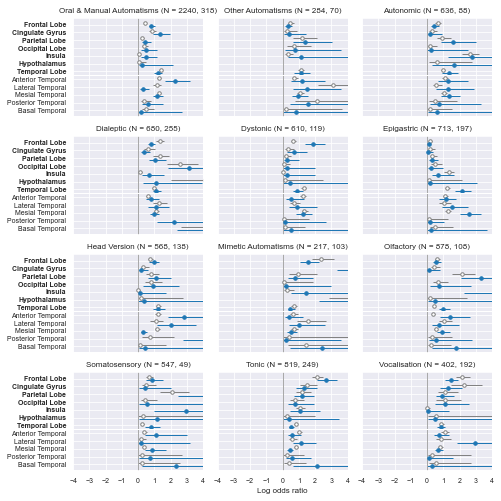

In [237]:
sns.set_style('darkgrid')

plotter.plot_proportion_ci_forest_plot(
    proportion_df_1 = odds_dfs['full']['or'],
    confint_df_1 = [df for df in odds_dfs['full']['confints']],
    counts_df_1 = results['full']['counts'],
    colors = colors,
    legend_labels = legend_labels,
    proportion_df_2 = odds_dfs['spontaneous']['or'],
    confint_df_2 = [df for df in odds_dfs['spontaneous']['confints']],
    counts_df_2 = results['spontaneous']['counts'],
    y_labels = labels.clean_localisations(odds_dfs['full']['or'].columns),
    overlapping=False,
    ax_titles = labels.clean_semiologies(odds_dfs['full']['or'].index),
    xlim = [-4,4], 
    xticks = np.arange(-4, 5, 1),
    vline = 0.0,
    xlabel = 'Log odds ratio',
    figsize = (7, 7),
    plotter_settings = plotter_settings,
    special_y_titles = special_y_index,
)
    
# plt.savefig(f'scripts/figures/working_figures_4/fig-3/normalised_log.png', dpi=300, pad_inches=0.5)

## TL as a single category

In [33]:
results = {}
for study_type, query_result in query_results.items():
    result = interogate_queries.summarise_query(
        query_result,
        axis = 'semiology',
        region_names = region_names,
        normalise = True,
        merge_temporal = True,
        semiologies_of_interest = sorted_semiologies[-12:],
        drop_other_semiology = True,
        merge_other_regions = True,
        drop_other_regions = False,
        confint_method = 'bootstrap',
        bootstrapping_samples = 10)
    
    results[study_type] = result

/Volumes/Encrypted/Semiology-Visualisation-Tool/scripts/figures/interogate_queries.py:164: RuntimeWarning: invalid value encountered in true_divide
  top_level_ratio = (localising.values.T/all_regions.sum(1).values)[0]


In [48]:
total_row = all_dfs['full'][region_names['of_interest']].sum()
total_row['All other'] = all_dfs['full'][region_names['top_level_all_other']].sum().sum()
odds_dfs = {}
odds_dfs['full'] = odds_ratio_df(results['full']['counts'], total_row, log_odds = False)
odds_dfs['spontaneous'] = odds_ratio_df(results['spontaneous']['counts'], total_row, log_odds = False)

(<Figure size 504x576 with 12 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c38a2e0>,
       dtype=object))

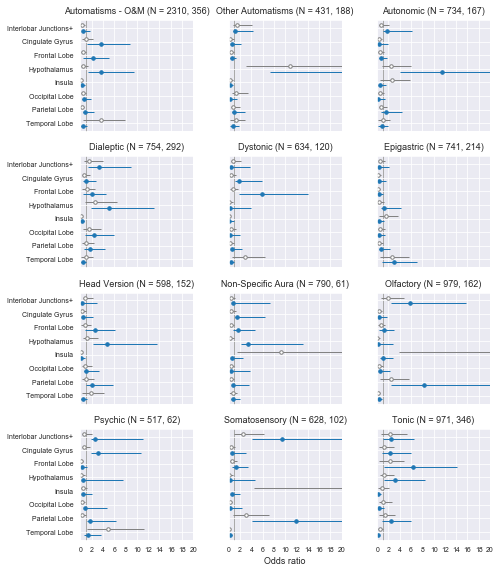

In [49]:
sns.set_style('darkgrid')
plotter.plot_proportion_ci_forest_plot(
    proportion_df_1 = odds_dfs['full']['or'],
    confint_df_1 = [df for df in odds_dfs['full']['confints']],
    counts_df_1 = results['full']['counts'],
    colors = colors,
    legend_labels = legend_labels,
    proportion_df_2 = odds_dfs['spontaneous']['or'],
    confint_df_2 = [df for df in odds_dfs['spontaneous']['confints']],
    counts_df_2 = results['spontaneous']['counts'],
    y_labels = labels.clean_localisations(odds_dfs['full']['or'].columns),
    overlapping=False,
    ax_titles = labels.clean_semiologies(odds_dfs['full']['or'].index),
    xlim = [-0.05,20],
    xticks = np.arange(0, 21, 2),
    vline = 1.0,
    xlabel = 'Odds ratio',
#     figsize = (7, 9),
    plotter_settings = plotter_settings,
)

plt.savefig(f'scripts/figures/working_figures/fig-3/normalised_top_level.eps', dpi=300, pad_inches=0.5)

# NMI/Correlation

In [709]:
import dython

In [765]:
results = {}
for study_type, query_result in query_results.items():
    result = interogate_queries.summarise_query(
        query_result,
        axis = 'zone',
        region_names = region_names,
        normalise = True,
        merge_temporal = False,
        semiologies_of_interest = sorted_semiologies[-20:],
        drop_other_semiology = True,
        merge_other_regions = True,
        drop_other_regions = False,
        confint_method = 'bootstrap',
        bootstrapping_samples = 10000)
    
    results[study_type] = result

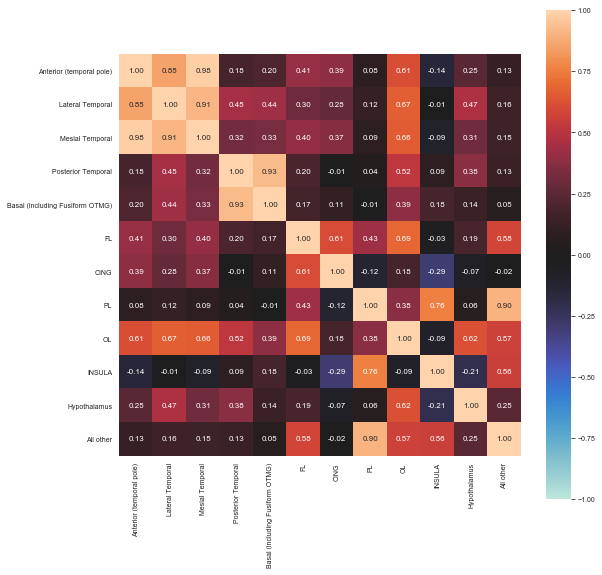

<Figure size 432x288 with 0 Axes>

In [766]:
dython.nominal.associations(results['full']['counts'], theil_u=True, figsize=(9, 9))
plt.tight_layout()

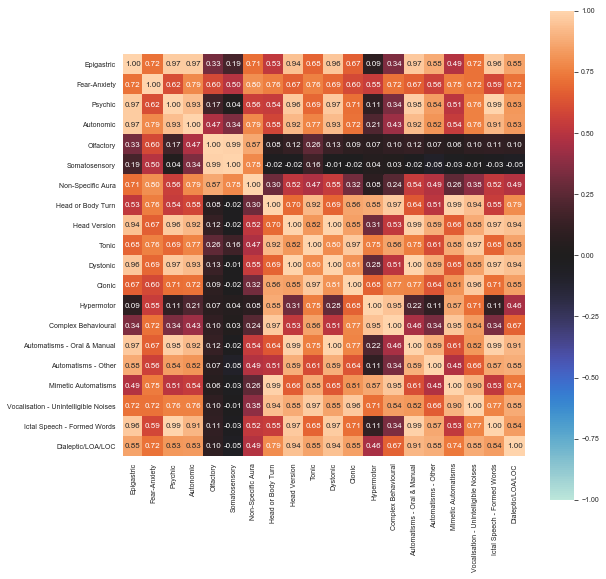

<Figure size 432x288 with 0 Axes>

In [767]:
dython.nominal.associations(results['full']['counts'].T, theil_u=True, figsize=(9, 9))
plt.tight_layout()

In [201]:
results = {}
for study_type, query_result in query_results.items():
    result = interogate_queries.summarise_query(
        query_result,
        axis = 'semiology', # 'zone'
        region_names = region_names_re,
        normalise = normalised,
        temporal_status = 'both',
        semiologies_of_interest = semiologies_100,
        drop_other_semiology = False,
        merge_other_regions = False,
        drop_other_regions = False,
        confint_method = 'bootstrap',
        bootstrapping_samples = 100, 
        order_of_regions = order_of_interest)
    
    results[study_type] = result

/Volumes/Encrypted/Semiology-Visualisation-Tool/scripts/figures/interogate_queries.py:415: RuntimeWarning: invalid value encountered in true_divide
  top_level_ratio = (localising.values.T/all_regions.sum(1).values)[0]


In [50]:
from mega_analysis.crosstab import hierarchy_dictionaries 

In [53]:
top_level_fl = hierarchy_dictionaries.frontal_postcodes['FL']

In [241]:
top_level_fl

['frontal pole',
 'Pre-frontal (BA 8, 9, 10, 11, 12, 13, 14, 24, 25, 32, 44, 45, 46, 47)',
 'Medial Frontal (include medial premotor and its constituents as its subsets)',
 'Primary Motor Cortex (Pre-central gyrus, BA 4, Rolandic)',
 'SFG (F1)',
 'MFG (F2)',
 'IFG (F3)\n(BA 44,45,47)',
 'Premotor frontal (posterior frontal)',
 'SMA (pre-central gyrus; posterior SFG, MFG)',
 'SSMA']

In [85]:
top_level_tl = hierarchy_dictionaries.temporal_postcodes['TL']

In [202]:
def get_counts_df_2(query_results, columns_of_interest):
    """
        Converts query results to matrix of counts by semiology and localisation

        Inputs
        - query_results: a dictionary where keys are semiologies and values are
        'query_inspection' for that semiology, as returned by QUERY_SEMIOLOGY
        - Requires region_names, a dictionary of defined groups of localisations
        - *merge_temporal: False if want to break down top level label TL into anterior,
        posterior etc.
        - *other_included: True if want to keep all top level localisation columns. False
        will drop interlobar junctions etc.

        Returns
        - counts_df: a matrix where columns are localisations and index are
        semiologies, where the values are the number of datapoints corresponding to that
        localisation and semiology
    """
    counts_matrix = []
    for semiology, value in query_results.items():
        query_inspection = value['query_inspection']
        semiology_counts = query_inspection[columns_of_interest].sum().values
        counts_matrix.append(semiology_counts)
    counts_df = pd.DataFrame(
        counts_matrix, index=query_results.keys(), columns=columns_of_interest)
    return counts_df

In [203]:
fl_counts = get_counts_df_2(query_results['full'], top_level_fl)

In [238]:
fl_normalised_sum = results['full']['counts']['FL'].sum()
fl_counts_sum = fl_counts.sum().sum()
ratio = fl_normalised_sum/fl_counts_sum
fl_counts_normalised = fl_counts*ratio
fl_counts_normalised_dropped = interogate_queries.merge_all_other_semiologies(fl_counts_normalised, semiologies_100)

In [205]:
fl_counts_sum

3000.0

In [206]:
fl_normalised_sum

2105.8223573135624

In [207]:
fl_counts_normalised.sum().sum()

2105.822357313563

In [208]:
total_row = all_dfs['full'][top_level_fl].sum()
total_row_fl = all_dfs['full']['FL'].sum()

In [138]:
total_row.sum()

2274.0

In [233]:
study_type = data_type = 'full'
top_level_columns = top_level_fl

In [230]:
total_row = all_dfs[study_type][top_level_columns].sum()

localising_sum = all_dfs[study_type]['Localising'].sum()
top_level_sums = all_dfs[study_type][region_names_re['top_level']].sum()
top_level_ratio = localising_sum/top_level_sums.sum()
top_level_normalised = top_level_ratio*top_level_sums

ratio = top_level_normalised['FL']/total_row.sum()
total_row_normalised = total_row*ratio

In [239]:
z = odds_ratio_df(fl_counts_normalised_dropped, total_row_normalised)

In [240]:
z['or']

localisation,"IFG (F3)\n(BA 44,45,47)",MFG (F2),Medial Frontal (include medial premotor and its constituents as its subsets),"Pre-frontal (BA 8, 9, 10, 11, 12, 13, 14, 24, 25, 32, 44, 45, 46, 47)",Premotor frontal (posterior frontal),"Primary Motor Cortex (Pre-central gyrus, BA 4, Rolandic)",SFG (F1),"SMA (pre-central gyrus; posterior SFG, MFG)",SSMA,frontal pole
semiology,,,,,,,,,,
All other,0.580186,1.252047,1.395380,0.627469,0.966285,0.994344,0.973157,1.090962,0.814396,1.510481
Automatisms - Oral & Manual,0.842285,1.552594,0.884513,1.060003,1.162322,0.788594,1.535079,0.173894,0.278103,1.315215
Automatisms - Other,4.095845,1.232133,1.074594,0.366965,0.856222,1.219797,0.582783,0.322843,3.187985,1.064869
Autonomic,9.817388,0.610460,1.404419,0.394121,0.102782,1.441106,3.479253,0.331994,1.064222,0.159541
Dialeptic/LOA/LOC,0.463879,0.665475,0.711404,2.911541,1.524621,0.392454,0.583858,0.665714,0.331833,0.626372
Dystonic,0.511003,0.345375,0.789909,3.109596,2.531433,0.375337,0.206311,0.079792,0.253237,0.415729
Epigastric,5.704814,0.244947,1.047274,4.847648,0.131372,0.274587,1.130420,0.422323,1.337796,0.911355
Head Version,0.922598,0.178729,0.156040,1.909154,0.926020,0.934961,1.797983,2.157044,3.227261,0.680176
Mimetic Automatisms,0.440600,1.785581,1.526112,0.290698,1.046225,1.226427,0.661178,0.033552,0.837492,2.145477


In [ ]:
total_row = all_dfs[study_type][top_level_columns].sum()

localising_sum = all_dfs[study_type]['Localising'].sum()

top_level_ratio = localising_sum/top_level_sums.sum()
top_level_normalised = top_level_ratio*top_level_sums

temporal_ratio = top_level_normalised['TL'] / temporal_sums.sum()
temporal_normalised = temporal_ratio * temporal_sums
normalised_row = pd.concat([temporal_normalised, top_level_normalised])
total_rows[study_type] = {
    'raw_row': total_row,
    'normalised_row': normalised_row
    }

In [141]:
total_rows = {}
for study_type in all_dfs.keys():
    total_row = all_dfs[study_type][region_names_re['low_level_temporal_of_interest'] + region_names_re['top_level']].sum()
    top_level_sums = all_dfs[study_type][region_names_re['top_level']].sum()
    temporal_sums = all_dfs[study_type][region_names_re['low_level_temporal_of_interest']].sum()
    
    localising_sum = all_dfs[study_type]['Localising'].sum()
    top_level_ratio = localising_sum/top_level_sums.sum()
    top_level_normalised = top_level_ratio*top_level_sums

    temporal_ratio = top_level_normalised['TL'] / temporal_sums.sum()
    temporal_normalised = temporal_ratio * temporal_sums
    normalised_row = pd.concat([temporal_normalised, top_level_normalised])
    total_rows[study_type] = {
        'raw_row': total_row,
        'normalised_row': normalised_row
    }

1        1.0
2       11.0
3       11.0
4        8.0
5        3.0
        ... 
2804     1.0
2805     1.0
2806     1.0
2807     1.0
2808     1.0
Name: Localising, Length: 2486, dtype: float64

In [143]:
top_level_normalised

TL              5794.181818
FL               638.606061
CING             101.242424
PL               202.484848
OL               189.829545
INSULA           764.185606
Hypothalamus      19.469697
Cerebellum         0.000000
dtype: float64

In [229]:
jesus

frontal pole                                                                    173.723469
Pre-frontal (BA 8, 9, 10, 11, 12, 13, 14, 24, 25, 32, 44, 45, 46, 47)           297.349938
Medial Frontal (include medial premotor and its constituents as its subsets)    230.284599
Primary Motor Cortex (Pre-central gyrus, BA 4, Rolandic)                        259.373180
SFG (F1)                                                                         71.105420
MFG (F2)                                                                        204.428082
IFG (F3)\n(BA 44,45,47)                                                          88.073759
Premotor frontal (posterior frontal)                                            347.446938
SMA (pre-central gyrus; posterior SFG, MFG)                                     124.434485
SSMA                                                                             41.208823
dtype: float64

In [126]:
fl_counts_normalised_dropped = interogate_queries.merge_all_other_semiologies(fl_counts_normalised, semiologies_100)

In [210]:
fl_counts_normalised.sum()

frontal pole                                                                    202.158946
Pre-frontal (BA 8, 9, 10, 11, 12, 13, 14, 24, 25, 32, 44, 45, 46, 47)           324.998584
Medial Frontal (include medial premotor and its constituents as its subsets)    263.227795
Primary Motor Cortex (Pre-central gyrus, BA 4, Rolandic)                        292.007367
SFG (F1)                                                                         85.636776
MFG (F2)                                                                        241.467630
IFG (F3)\n(BA 44,45,47)                                                         108.098881
Premotor frontal (posterior frontal)                                            403.615952
SMA (pre-central gyrus; posterior SFG, MFG)                                     138.984276
SSMA                                                                             45.626151
dtype: float64

In [127]:
odds_ratio_df(fl_counts_normalised_dropped, total_rows[data_type][row_type], log_odds = False)

,frontal pole,"Pre-frontal (BA 8, 9, 10, 11, 12, 13, 14, 24, 25, 32, 44, 45, 46, 47)",Medial Frontal (include medial premotor and its constituents as its subsets),"Primary Motor Cortex (Pre-central gyrus, BA 4, Rolandic)",SFG (F1),MFG (F2),"IFG (F3)\n(BA 44,45,47)",Premotor frontal (posterior frontal),"SMA (pre-central gyrus; posterior SFG, MFG)",SSMA
Epigastric,1.403882,7.721349,2.105822,0.701941,0.701941,0.000000,3.509704,0.000000,0.000000,0.000000
Autonomic,0.000000,2.105822,4.913586,5.615526,3.509704,2.105822,9.125230,0.701941,0.701941,0.701941
Olfactory,2.807763,14.038816,2.105822,22.462105,6.317467,6.317467,15.442697,6.317467,21.058224,3.509704
Somatosensory,1.403882,3.509704,2.105822,19.654342,4.211645,4.211645,8.423289,4.211645,17.548520,2.807763
Head Version,2.105822,8.423289,0.701941,4.211645,2.105822,0.701941,1.403882,5.615526,4.211645,2.105822
Tonic,14.740757,46.328092,25.269868,25.971809,11.932993,23.164046,12.634934,55.453322,20.356283,7.721349
Dystonic,3.509704,29.481513,8.423289,4.913586,0.701941,3.509704,2.105822,29.481513,0.000000,0.000000
Automatisms - Oral & Manual,23.865987,34.395099,23.164046,23.865987,11.231053,31.587335,8.423289,42.818388,2.807763,1.403882
Automatisms - Other,2.105822,1.403882,2.807763,3.509704,0.000000,2.807763,3.509704,3.509704,0.000000,1.403882
Mimetic Automatisms,30.885395,10.529112,31.587335,30.183454,4.913586,31.587335,4.211645,35.798980,0.000000,3.509704


In [106]:
fl_breakdown_sum

3000.0

In [ ]:
top_level_ratio = (localising.T/all_regions.sum(1).values)[0]
top_level_normalised = all_regions.multiply(top_level_ratio, axis='rows')

In [87]:
tl_counts = get_counts_df_2(query_results['full'], top_level_tl)

In [68]:
fl_counts = get_counts_df_2(query_results['full'], top_level_fl)

In [61]:
total_row = all_dfs[study_type][top_level_fl].sum()

In [81]:
total_row.sum()

525.0

In [95]:
fl_counts.sum()

frontal pole                                                                    288.0
Pre-frontal (BA 8, 9, 10, 11, 12, 13, 14, 24, 25, 32, 44, 45, 46, 47)           463.0
Medial Frontal (include medial premotor and its constituents as its subsets)    375.0
Primary Motor Cortex (Pre-central gyrus, BA 4, Rolandic)                        416.0
SFG (F1)                                                                        122.0
MFG (F2)                                                                        344.0
IFG (F3)\n(BA 44,45,47)                                                         154.0
Premotor frontal (posterior frontal)                                            575.0
SMA (pre-central gyrus; posterior SFG, MFG)                                     198.0
SSMA                                                                             65.0
dtype: float64

In [ ]:
get_counts_df_2(query_results['full'], top_level_fl)

In [77]:
top_level_ratio

0.9734848484848485

In [ ]:
total_rows = {}
for study_type in all_dfs.keys():
    total_row = all_dfs[study_type][region_names_re['low_level_temporal_of_interest'] + region_names_re['top_level']].sum()
    top_level_sums = all_dfs[study_type][region_names_re['top_level']].sum()
    temporal_sums = all_dfs[study_type][region_names_re['low_level_temporal_of_interest']].sum()
    
    localising_sum = all_dfs[study_type]['Localising'].sum()
    top_level_ratio = localising_sum/top_level_sums.sum()
    top_level_normalised = top_level_ratio*top_level_sums

    temporal_ratio = top_level_normalised['TL'] / temporal_sums.sum()
    temporal_normalised = temporal_ratio * temporal_sums
    normalised_row = pd.concat([temporal_normalised, top_level_normalised])
    total_rows[study_type] = {
        'raw_row': total_row,
        'normalised_row': normalised_row
    }

In [78]:
temporal_ratio

0.7415129022500407

In [57]:
total_row

Anterior (temporal pole)           3073.0
Lateral Temporal                    535.0
Mesial Temporal                    4075.0
Posterior Temporal                   51.0
Basal (including Fusiform OTMG)      80.0
TL                                 5952.0
FL                                  656.0
CING                                104.0
PL                                  208.0
OL                                  195.0
INSULA                              785.0
Hypothalamus                         20.0
Cerebellum                            0.0
dtype: float64

In [ ]:
def odds_ratio_df(counts, total_row, log_odds=False):
    melted = counts.reset_index().melt(id_vars='index')
    melted = melted.rename(columns={'index': 'semiology', 'variable': 'localisation', 'value': 'a'})
    melted['localisation_total'] = np.zeros(len(melted))
    for localisation, total in total_row.to_dict().items():
        mask = melted['localisation'] == localisation
        melted.loc[mask, 'localisation_total'] = total
        
    melted['c'] = melted['localisation_total'] - melted['a']
    
    melted['semiology_total'] = np.zeros(len(melted))
    for semiology, total in counts.sum(1).to_dict().items():
        mask = melted['semiology'] == semiology
        melted.loc[mask, 'semiology_total'] = total
        
    melted['b'] = melted['semiology_total']-melted['a']
    
    melted['d'] = np.repeat(total_row.sum(), len(melted)) - (melted['a'] + melted['b'] + melted['c'])
    
    melted['OR'] = np.nan
    melted['OR_lower_ci'] = np.nan
    melted['OR_upper_ci'] = np.nan
    
    for i in melted.index:
        contingency_table = Table2x2(
        [[melted.loc[i, 'a'], melted.loc[i, 'b']],
         [melted.loc[i, 'c'], melted.loc[i, 'd']]] )
        
        if not log_odds:
            melted.loc[i, 'OR'] = contingency_table.oddsratio
            melted.loc[i, 'OR_lower_ci'] = contingency_table.oddsratio_confint(alpha = 0.05)[0]
            melted.loc[i, 'OR_upper_ci'] = contingency_table.oddsratio_confint(alpha = 0.05)[1]
        else:
            melted.loc[i, 'OR'] = contingency_table.log_oddsratio
            melted.loc[i, 'OR_lower_ci'] = contingency_table.log_oddsratio_confint(alpha = 0.05)[0]
            melted.loc[i, 'OR_upper_ci'] = contingency_table.log_oddsratio_confint(alpha = 0.05)[1]

    or_pivot = melted.pivot_table(index=['semiology',], columns='localisation', values='OR')
    or_l_pivot = melted.pivot_table(index=['semiology',], columns='localisation', values='OR_lower_ci')
    or_u_pivot = melted.pivot_table(index=['semiology',], columns='localisation', values='OR_upper_ci')
    
    or_dfs = {
        'counts': counts,
        'or': or_pivot,
        'confints': (or_l_pivot, or_u_pivot)
    }
    
    return or_dfs